# LightGBM

https://lightgbm.readthedocs.io/en/latest/Python-Intro.html

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import lightgbm as lgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
import numpy as np
from datetime import datetime
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from preprocess import Preprocess
import seaborn as sns

pd.set_option("display.max_columns", None)

Importing data and defining column names

In [ ]:
## Please change here the name of the folder containing the data
data_path = "../../data/"

In [4]:
# name of the target columns
label_col = "Label"

train_df = pd.read_csv(data_path + "train.csv")
drop_cols = [
    # "time",
    "SNo"
]

# Droping unwanted data
train_df = train_df.drop(drop_cols, axis=1)
train_df = train_df.sort_values(by="Label")

## OPTIONAL: drop duplicates
# train_data = train_df.drop_duplicates(keep="last")

## OPTIONAL: SELECT COLUMNS
# train_df = train_df[['lat', 'TS', 'TMQ', 'U850', 'PS', 'Z1000', 'PSL', 'Z200', 'lon', 'UBOT', 'T500', "Label"]]
# train_data = train_df.drop_duplicates(keep="last")

# Separate the validation data
train_data = train_df.sample(frac=0.7)
validation_data = train_df.iloc[~train_data.index]
X = train_data.drop(["Label"], axis=1).copy()
y = train_data[label_col].copy()
X_valid = validation_data.drop(["Label"], axis=1).copy()
y_valid = validation_data[label_col].copy()

In [7]:
# Scale data
scaler = StandardScaler()
X_valid = scaler.fit_transform(X_valid)
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

Train lightgbm

In [10]:
# Define parameters (adjust these as per your needs)
parameters = {
    # "objective": "multiclass",
    # "num_class": 3,
    # 'eval_metric': ["accuracy", "softmax"],
    "class_weight": {0: 1, 1: 3, 2:1.3},
    'is_unbalance': 'true',
#     'boosting': 'gbdt',
    # "max_bin": 3,
    # "max_depth": 4,
    # "num_leaves": 16,
    # "num_iterations": 200,
#     "n_jobs": 1,
#     "lambda_l1": 0.2,  # L1 regularization term. Adjust as needed.
#     "lambda_l2": 0.2,  # L2 regularization term. Adjust as needed.
#     # "verbose_eval": -1,
#     # "early_stopping_round": 4,
}

# # Train model
model_lgbm = lgb.LGBMClassifier(**parameters, boosting_type='gbdt', colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective="multiclass", num_class=3,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0, verbose=-100)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
scores = cross_validate(model_lgbm, X=X_scaled, y=y,cv=5,scoring="accuracy")
model_lgbm.fit(X=X_scaled, y=y)

LGBMClassifier(class_weight={0: 1, 1: 3, 2: 1.3}, is_unbalance='true',
               n_jobs=-1, num_class=3, objective='multiclass', random_state=123,
               verbose=-100)

Evaluating model

In [11]:
print("scores:", scores["test_score"])
print("mean:", scores["test_score"].mean())
print("diff :", scores["test_score"].max() - scores["test_score"].min())

scores: [0.87362374 0.882719   0.88732844 0.88653048 0.88397702]
mean: 0.8828357375439602
diff : 0.013704695777755793


In [12]:
y_valid.value_counts()


0    24607
2     5434
1     1291
Name: Label, dtype: int64

In [13]:
confusion_matrix(y_valid, model_lgbm.predict(X=X_valid),)

array([[22907,   428,  1272],
       [  131,  1158,     2],
       [ 1146,    76,  4212]])

In [14]:
accuracy_score(model_lgbm.predict(X=X_valid), y_valid)

0.9024958508872718

In [15]:
y_valid.value_counts(normalize=True)

0    0.785363
2    0.173433
1    0.041204
Name: Label, dtype: float64

In [194]:
pd.Series(model_lgbm.predict(X=X_valid)).value_counts(normalize=True)

0    0.812173
2    0.149464
1    0.038363
dtype: float64

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

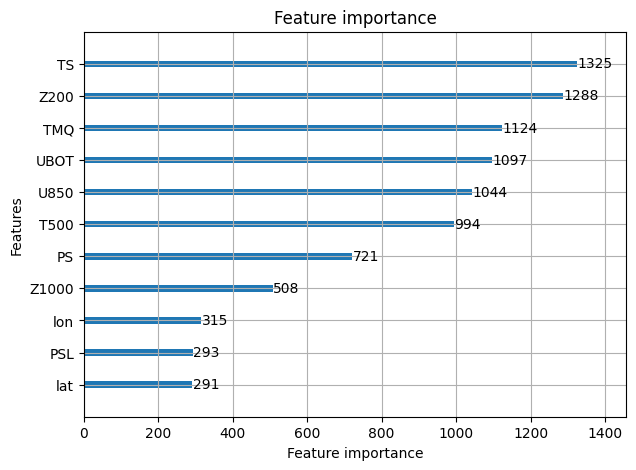

In [195]:
# Feature importance
lgb.plot_importance(model_lgbm, height=0.2, figsize=(7,5))

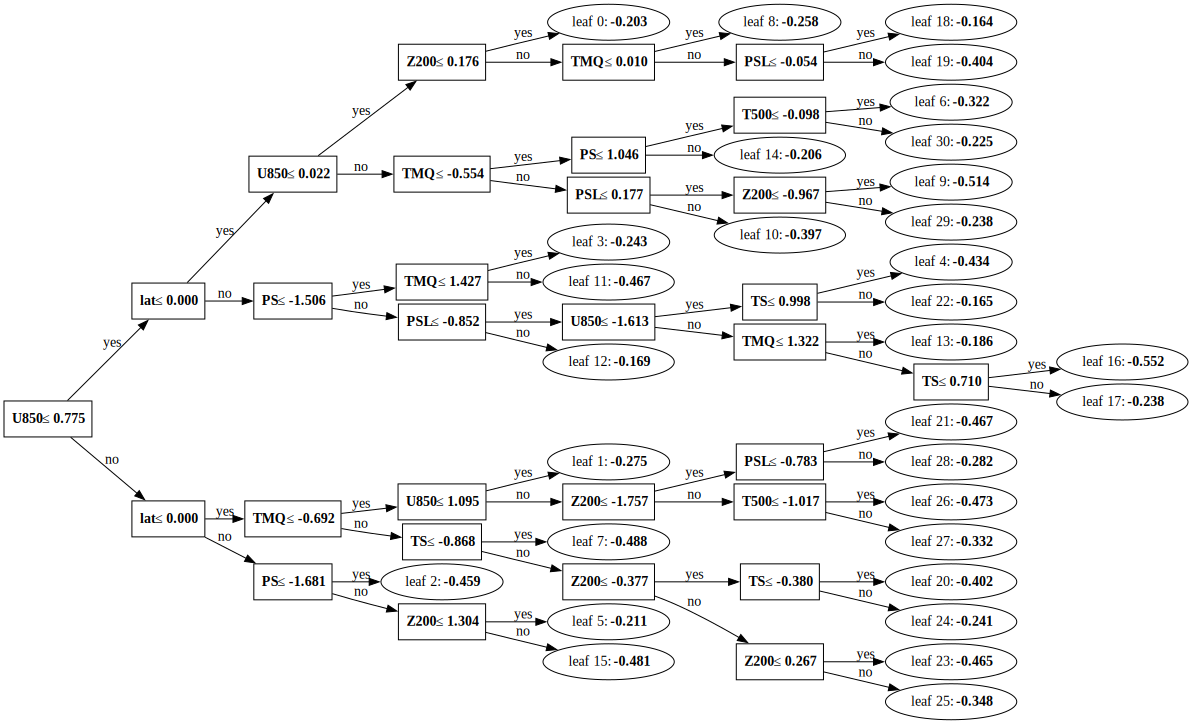

In [199]:
lgb.create_tree_digraph(model_lgbm)

This tree is really complex

---

Test data

In [196]:
# Read and select columns
test_data = pd.read_csv(data_path + "test.csv")
test_data = test_data[["SNo", 'lat', 'TS', 'TMQ', 'U850', 'PS', 'Z1000', 'PSL', 'Z200', 'lon', 'UBOT', 'T500']]

# Normalize data
scaler = StandardScaler()
test_data_sel = scaler.fit_transform(test_data.drop("SNo", axis=1))

In [200]:
# Predict data
test_data['Label'] = model_lgbm.predict(test_data_sel)
submission = test_data[["SNo", "Label"]].copy()

In [203]:
# Export data
submission.to_csv(f"predictions_lightgbm_{datetime.now()}_same_log_reg_cols.csv", index=False)